# Generative Adversarial Networks

In [1]:
# imports 
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as pltgrid
import numpy as np
import numpy.random as rng

In [2]:
# neural network class
class neural_net(object):
    ''' Neural Network Class'''
    def __init__(self, layer_sizes, activationFn=tf.nn.relu):
        self.activationFn = activationFn # network activation function
        self.weights = []
        self.biases = []
        for s1,s2 in zip(layer_sizes[0:-1], layer_sizes[1:]):
            self.weights += [tf.Variable(tf.truncated_normal(shape=[s1,s2], stddev=1./tf.sqrt(s2*1.)))]
            self.biases += [tf.Variable(tf.zeros(shape= [s2]))]
    ''' Logits function'''
    def get_logits(self, ip):
        h = ip   #initilaize layer with input
        ###  forward pass through network layers ###
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            h = self.activationFn(tf.matmul(h,w)+b)
        return tf.matmul(h, self.weights[-1])+self.biases[-1]
    '''Network output'''
    def out(self, ip):
        return tf.nn.sigmoid(self.get_logits(ip))

In [3]:
''' digits plotting function'''
def plot_digits(digits):
    l = int(np.ceil(np.sqrt(digits.shape[0])))
    fig = plt.figure(figsize=(l,l))
    gs = pltgrid.GridSpec(l,l)
    for i, d in enumerate(digits):
        plt.subplot(gs[i])
        plt.imshow(digits[i].reshape(28, 28), cmap='Greys_r')
        plt.axis('off')
    return fig

''' sampling function'''
def sample_z(n, s):
    return rng.uniform(-.5, .5, size=[n, s])
    

Extracting /Users/gamal/git_local_repo/code_challenge/data/data/MNIST/train-images-idx3-ubyte.gz
Extracting /Users/gamal/git_local_repo/code_challenge/data/data/MNIST/train-labels-idx1-ubyte.gz
Extracting /Users/gamal/git_local_repo/code_challenge/data/data/MNIST/t10k-images-idx3-ubyte.gz
Extracting /Users/gamal/git_local_repo/code_challenge/data/data/MNIST/t10k-labels-idx1-ubyte.gz


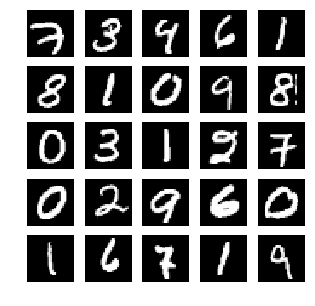

In [4]:
# load data
from tensorflow.examples.tutorials import mnist
directory = '/Users/gamal/git_local_repo/code_challenge/data/'
mnist_data = mnist.input_data.read_data_sets(directory + 'data/MNIST', one_hot=True)
l = mnist_data.train.images.shape[1]
plot_digits(mnist_data.train.images[0:25])

In [5]:
g = tf.Graph()
with g.as_default():
    # Discriminator network
    layer_sizes = (784, 200, 200, 1)
    ip_imgs = tf.placeholder(shape=[None, layer_sizes[0]], dtype=tf.float32) # input to network
    D = neural_net(layer_sizes=layer_sizes)

    # Generator network
    latent_size = 100
    layer_sizes = (latent_size, 200, 200, 784)
    Z = tf.placeholder(shape=[None, latent_size], dtype=tf.float32)
    G = neural_net(layer_sizes=layer_sizes)
    # define losses
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D.get_logits(ip_imgs), \
                                                                    labels = tf.ones_like(D.get_logits(ip_imgs))))+ \
             tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D.get_logits(G.out(Z)), \
                                                                    labels = tf.zeros_like(D.get_logits(G.out(Z)))))
        
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D.get_logits(G.out(Z)), \
                                                                    labels = tf.ones_like(D.get_logits(G.out(Z)))))
    
    # solvers 
    learning_rate = 0.001
    optimize_D = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list = D.weights+D.biases)
    optimize_G = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list = G.weights+G.biases)

    init = tf.global_variables_initializer()

In [ ]:
max_iter = 10000
batch_size = 100
with tf.Session(graph=g) as sess:
    init.run()
    for i in range(max_iter):
        feed_dict = {ip_imgs: mnist_data.train.next_batch(batch_size)[0], Z: sample_z(batch_size, latent_size)}
        for k in range(1):
            _, D_l = sess.run([optimize_D, D_loss], feed_dict=feed_dict)
        feed_dict = {Z: sample_z(batch_size, latent_size)}
        _, G_l = sess.run([optimize_G, G_loss], feed_dict=feed_dict)

        if i%1000==0:
            print (i, D_l, G_l)
    feed_dict = {Z: sample_z(25, latent_size)}
    plot_digits(sess.run(G.out(Z), feed_dict=feed_dict))
    plt.show()

(0, 2.7928391, 1.6769786)
(1000, 7.465099e-13, 29.083002)
(2000, 6.4936416e-09, 19.362225)
(3000, 3.0863723e-07, 16.444592)
(4000, 1.9911814e-20, 62.248497)
(5000, 4.4138281e-07, 14.642342)
